In [37]:
import numpy as np
import pickle
import random
from random import choices
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Dot,CuDNNLSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import optimizers
from keras import backend as K
from keras.losses import mse, binary_crossentropy
import matplotlib.pyplot as plt
import os
import librosa

# Problem 1 Siamese Network

## Formula to properly process data

In [38]:
def gen_data(dat,ind, num_classes):
    par = []; lab = []; L = 9
    for d in range(num_classes):
        for i in range(L):
            #posetive
            s1, s2 = ind[d][i], ind[d][i + 1]
            par += [[dat[s1], dat[s2]]]
            
            #Negative
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            s1, s2 = ind[d][i], ind[dn][i]
            par += [[dat[s1], dat[s2]]]
            
            #assigining posetive and negative label
            lab += [1, 0]
    return np.array(par), np.array(lab)

## Loading Files

In [39]:
with open('data/hw4_trs.pkl', 'rb') as f:
    train_data = pickle.load(f)

In [40]:
with open('data/hw4_tes.pkl', 'rb') as f:
    test_data = pickle.load(f)

## Setting up data

### Setting up train data

In [41]:
tst = []
for i in train_data:
    tst.append(librosa.stft(i, n_fft= 1024, hop_length= 512))
tst = np.array(tst)
samp = np.zeros((500,513,45))
for x in range(0,500):
    samp[x] = np.concatenate((tst[x], np.zeros((513,13))), axis = 1)

C:\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


In [42]:
y_train = []
for x in range(0,50):
    y_train += [x for _ in range(10)]
y_train = np.array(y_train)

### Setting up test data

In [43]:
tst2 = []
for i in test_data:
    tst2.append(librosa.stft(i, n_fft= 1024, hop_length= 512))
tst2 = np.array(tst2)

In [44]:
y_test = []
for x in range(0,20):
    y_test += [x for _ in range(10)]
y_test = np.array(y_test)

### Taking magnitude and transposing 

In [45]:
samp  = np.abs(samp).reshape((-1,45,513))
tst2  = np.abs(tst2).reshape((-1,45,513))

### Setting train and test data for modeling

In [46]:
#Setting data up for training
tot_classes = 50
int_shape = samp.shape[1:]
inds = [np.where(y_train == i)[0] for i in range(tot_classes)]
train_data, train_label = gen_data(samp, inds,tot_classes)

#Setting data up for testing
tot_classes = 20
inds = [np.where(y_test == i)[0] for i in range(tot_classes)]
test_data, test_label = gen_data(tst2, inds,tot_classes)

#Restating total classes
tot_classes = len(np.unique(y_train))


##  Modeling

In [57]:
def base_net(shp):
    input = Input(shape=shp)
    x = CuDNNLSTM(units=256, return_sequences=True, kernel_initializer='glorot_normal')(input)
    x = Dropout(0.05)(x)
    x = Dense(units=513, activation="relu")(x)
    x = Flatten()(x)
    return Model(input, x)

### Generating Model & Setting up loss and optimizer

In [58]:
epochs = 100
net = base_net(int_shape)

#Defining 2 Inputs
input_a = Input(shape=int_shape)
input_b = Input(shape=int_shape)

#Pushing them through the encoder
processed_a = net(input_a)
processed_b = net(input_b)

#Taking outputs and making a predictions
x = Dot(-1,normalize=True)([processed_a, processed_b])
predictions = Dense(1, activation='sigmoid')(x)

model = Model([input_a, input_b], predictions)
ad = optimizers.nadam(lr=0.01)
model.compile(loss='binary_crossentropy',optimizer=ad, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 45, 513)      0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 45, 513)      0                                            
__________________________________________________________________________________________________
model_11 (Model)                (None, 23085)        921345      input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
dot_6 (Dot)                     (None, 1)            0           model_11[1][0]                   
          

### Setting up EarlyStop and Storage of best model

In [59]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('bst_model/.mdlacc_wts.hdf5', save_best_only=True, monitor='val_acc', mode='max')
mcp_save2 = ModelCheckpoint('bst_model/.mdlloss_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

### Training Model

In [60]:
%%time
model.fit([train_data[:, 0], train_data[:, 1]], train_label,
          batch_size=1,
          epochs=epochs,
          validation_data=([test_data[:, 0], test_data[:, 1]], test_label),
          verbose = 1,
          callbacks=[earlyStopping,mcp_save,mcp_save2] )

Train on 900 samples, validate on 360 samples
Epoch 1/100
900/900 [==============================] - 13s 15ms/step - loss: 0.6720 - acc: 0.6156 - val_loss: 0.6305 - val_acc: 0.6778
Epoch 2/100
900/900 [==============================] - 12s 13ms/step - loss: 0.5350 - acc: 0.8011 - val_loss: 0.6188 - val_acc: 0.6722
Epoch 3/100
900/900 [==============================] - 12s 13ms/step - loss: 0.4463 - acc: 0.8322 - val_loss: 0.5320 - val_acc: 0.7389
Epoch 4/100
900/900 [==============================] - 12s 13ms/step - loss: 0.3749 - acc: 0.8622 - val_loss: 0.5592 - val_acc: 0.7389
Epoch 5/100
900/900 [==============================] - 12s 14ms/step - loss: 0.3499 - acc: 0.8644 - val_loss: 0.5803 - val_acc: 0.7167
Epoch 6/100
900/900 [==============================] - 12s 13ms/step - loss: 0.2941 - acc: 0.8922 - val_loss: 0.5810 - val_acc: 0.6972
Epoch 7/100
900/900 [==============================] - 11s 12ms/step - loss: 0.2850 - acc: 0.8889 - val_loss: 0.6526 - val_acc: 0.7194
Epoch 8/1

## Results

In [61]:
 def get_acc(y_true, y_pred):
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

### Loading model with best loss

In [64]:
#I had many models but am loading the weight of the one that did the best out of all my itterations 
#hence the 0 and the end of the name, i will attach this to the hw
model.load_weights('bst_model/.mdlloss_wts0.hdf5')

### Measuring Accuracy

In [65]:
y_pred = model.predict([train_data[:, 0], train_data[:, 1]])
train_acc = get_acc(train_label, y_pred)

y_pred = model.predict([test_data[:, 0], test_data[:, 1]])
test_acc = get_acc(test_label, y_pred)

print(f'The accuracy on the training set is: {round(100 * train_acc,2)}%')
print(f'The accuracy on the testing set is: {round(100 * test_acc,2)}%')

The accuracy on the training set is: 89.33%
The accuracy on the testing set is: 76.39%


# Problem 2 Variational AutoEncoder


## Loading Data

In [66]:
with open('data/hw4_tr7.pkl', 'rb') as f:
    train_data = pickle.load(f)

In [67]:
with open('data/hw4_te7.pkl', 'rb') as f:
    test_data = pickle.load(f)

### Setting Up Data for Dense VAE

In [68]:
x_train = np.reshape(train_data , [-1, 28*28])
x_test = np.reshape(test_data, [-1, 28*28])

y_test = np.array([7 for x in range(0,x_test.shape[0])])

## Modeling

### Reparameterization trick

In [69]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


### Setting up Model Parameters

In [70]:
ogdim  = 28*28
int_shp = (ogdim, )
btch = 128
totdim = 3
epochs = 50

In [71]:
inputs = Input(shape=int_shp, name='encoder_input')
x = Dense(512, activation='relu', name = "hidden_layer")(inputs)
z_mean = Dense(totdim, name='z_mean')(x)
z_log_var = Dense(totdim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(totdim,), name='z')([z_mean, z_log_var])

### Defining Encoder

In [72]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            1539        hidden_layer[0][0]               
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 3)            1539        hidden_layer[0][0]               
__________________________________________________________________________________________________
z (Lambda)

### Defining Decoder

In [73]:
# build decoder model
latent_inputs = Input(shape=(totdim,), name='z_sampling')
x = Dense(512, activation='relu')(latent_inputs)
outputs = Dense(ogdim, activation='sigmoid')(x)

In [74]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 3)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               2048      
_________________________________________________________________
dense_16 (Dense)             (None, 784)               402192    
Total params: 404,240
Trainable params: 404,240
Non-trainable params: 0
_________________________________________________________________


### Defining VAE Network with both Encoder & Decoder

In [75]:
outputs = decoder(encoder(inputs)[2])

#for the vae the original inputs to the docoded outputs
vae = Model(inputs, outputs, name='vae_mlp')

### Setting up loss KL divergence + mse to lower distance between clusters

In [76]:
re_loss= mse(inputs, outputs)
re_loss *= ogdim

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(re_loss + kl_loss)

### Compiling VAE Model

In [77]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 404998    
_________________________________________________________________
decoder (Model)              (None, 784)               404240    
Total params: 809,238
Trainable params: 809,238
Non-trainable params: 0
_________________________________________________________________


### Training VAE Model

In [78]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=btch,
        validation_data=(x_test, None), verbose = 0)
vae.save_weights('bst_model/vae_mlp_mnist.h5')

## Latent Variable Research By Sampling from Normal Distribution

In [79]:
def genPlot(encoder,repl, tstvec = 0):
    n = 100
    grid_x = np.linspace(-2, 2, n)
    tst = []
    #depending on the testing latent vector setting the other two variable to a random normal supplied
    for j, xi in enumerate(grid_x):
        if tstvec == 0:
            z_sample = np.array([[xi,repl[0],repl[1]]])
        elif tstvec == 1:
            z_sample = np.array([[repl[0],xi,repl[1]]])
        else:
            z_sample = np.array([[repl[0],repl[1],xi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded.reshape((28,28))
        tst.append(digit)

    y_ax = 10
    x_ax = 10
    
    fig, axes = plt.subplots(x_ax,y_ax,figsize  = (10,10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    ct  = 0
    for i in range(x_ax):
      for j in range(y_ax):
        axes[i,j].imshow(tst[ct])
        ct +=1


In [80]:
np.random.seed(10)
repl = np.random.normal(size = 2)

### Testing Latent Variable 1


There is a angle tranformation as you move southeast

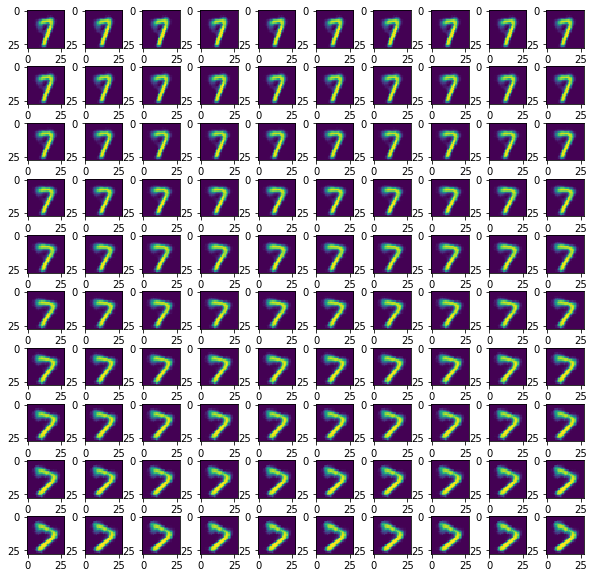

In [81]:
genPlot(encoder, repl, tstvec = 0)

### Testing Latent Variable 2

There is a angle tranformation as you move southeast

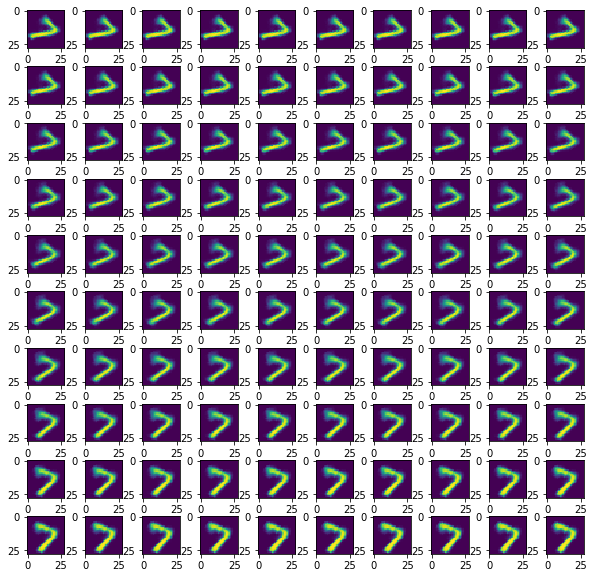

In [82]:
genPlot(encoder,repl, tstvec = 1)

### Testing Latent Variable 3

There seems to be no shifting in this variable

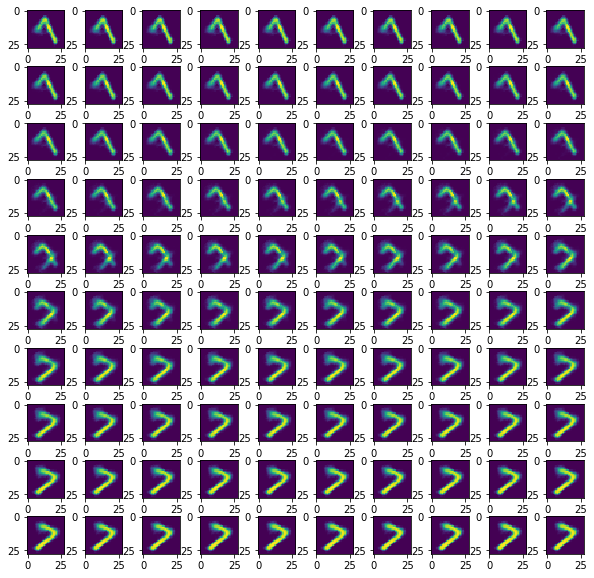

In [83]:
genPlot(encoder,repl, tstvec = 2)

# References

* https://keras.io/examples/mnist_siamese/
* https://keras.io/examples/variational_autoencoder/